In [235]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## 1. Dimension reduction using pricipal component analysis(PCA)

### 1.1 Using Singular-Value Decompositiom (SVD) method, please decpompose 1st and 2nd pricipal components and project them to the data

In [236]:
# read data 
data = pd.read_csv('fashion_mnist1.csv')

In [237]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,2,...,116,30,0,0,0,0,1,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,6,...,18,0,0,0,0,0,0,0,0,0


In [238]:
data.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
9995,0,0,0,0,0,0,0,0,0,0,...,132,103,78,77,0,0,2,0,0,0
9996,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,2,0,0,0,0,0,0,1,0,0,...,229,217,231,137,0,0,0,0,0,0
9999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
# separate lables and features
features = data.drop('label', axis=1).values  # features (pixel values)
labels = data['label'].values  # labels (clothing types)

In [240]:
# center the dataset (subtract the mean of each feature)
X_centered = features - features.mean(axis=0)

In [241]:
# perform SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

In [242]:
# extract the first two principal components (c1 and c2)
c1 = Vt.T[:, 0]  # First principal component
c2 = Vt.T[:, 1]  # Second principal component

In [243]:
# transform the data onto the first two principal components
X_pca_svd = X_centered @ Vt.T[:, :2]

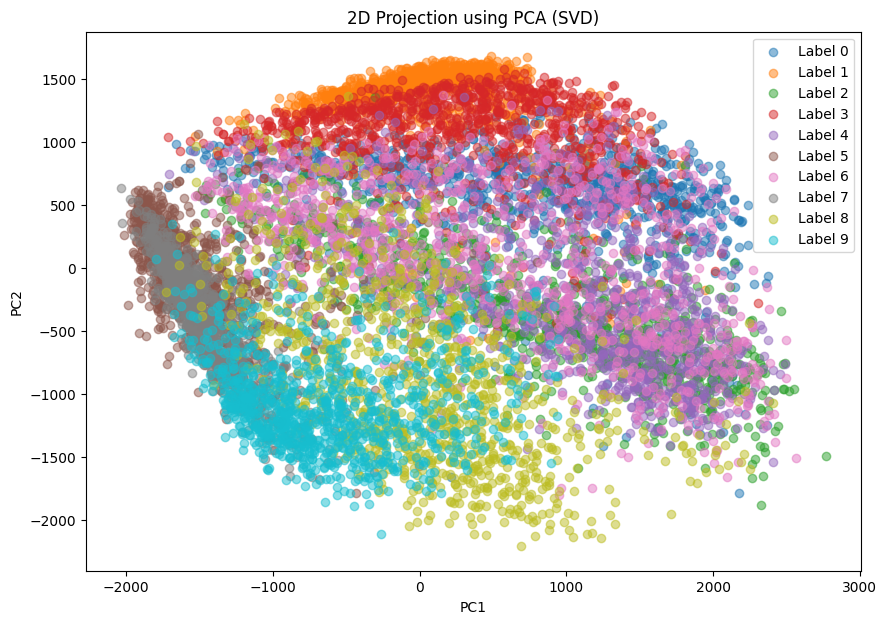

In [244]:

# plot the results with different colors for labels
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(X_pca_svd [idx, 0], X_pca_svd [idx, 1], label=f'Label {label}', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('2D Projection using PCA (SVD)')
plt.show()

### 1.2 As we discussed during the class, we can compress images using PCA

In [245]:
# Select 10 images, one from each label
selected_images = []
for label in np.unique(labels):
    selected_images.append(features[labels == label][0])  # Select first image of each label
selected_images = np.array(selected_images)

In [246]:
# function to compress images using PCA
def compress_image(image, k):
    image_centered = image.reshape(28, 28) - image.mean()  # Center the image
    U, S, Vt = np.linalg.svd(image_centered, full_matrices=False)  # Perform SVD
    compressed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))  # Compress to k dimensions
    return compressed + image.mean()

In [247]:
# visualize original and compressed images for different k
k_values = [2, 5, 10]
num_images = len(selected_images)

plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

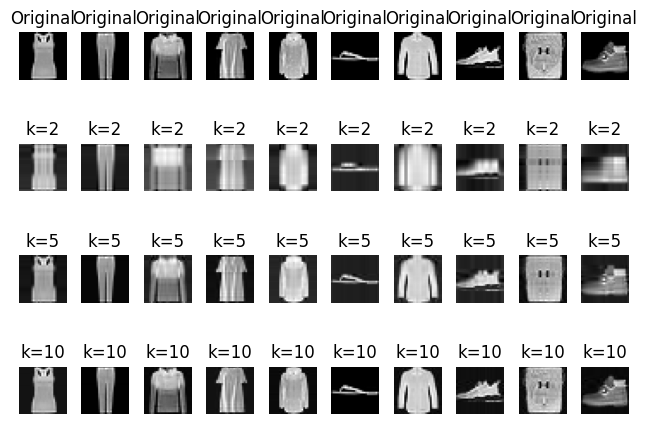

In [248]:
# loop over the images
for i, img in enumerate(selected_images):
    # plot the original image
    plt.subplot(4, num_images, i+1)  # Changed 3 rows to 4 rows to avoid the out-of-bounds issue
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')  # Turn off axis for clarity

    # plot the compressed images for different values of k
    for j, k in enumerate(k_values):
        compressed_img = compress_image(img, k)
        plt.subplot(4, num_images, (j+1)*num_images + i+1)
        plt.imshow(compressed_img, cmap='gray')
        plt.title(f'k={k}')
        plt.axis('off')  # turn off axis for clarity

plt.tight_layout()
plt.show()

## 2.Dimension reduction using t-SNE

### 2.1 Please build t-SNE algorithm from scratch bases on the below equations

In [249]:
# Step 1: Normalize the data (this replaces StandardScaler)
def normalize_data(X):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    std_X[std_X == 0] = 1  # Avoid division by zero
    return (X - mean_X) / std_X

In [250]:
# Step 2: Pairwise affinities in high-dimensional space (P_ij)
def compute_pairwise_affinities(X, perplexity=30, tol=1e-5, max_iter=50):
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)  # Squared Euclidean distances
    
    epsilon = 1e-8
    D = np.maximum(D, epsilon)  # Avoid zero distances for stability
    
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    log_perplexity = np.log(perplexity)

    def h_beta(Di, beta):
        P = np.exp(-Di * beta)
        sum_P = np.sum(P)
        
        if sum_P == 0:
            sum_P = epsilon
        
        H = np.log(sum_P) + beta * np.sum(Di * P) / sum_P
        P = P / sum_P
        return H, P

    for i in range(n):
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = h_beta(Di, beta[i])
        Hdiff = H - log_perplexity
        tries = 0
        
        beta_min = -np.inf
        beta_max = np.inf

        # Binary search to optimize beta
        while np.abs(Hdiff) > tol and tries < max_iter:
            if Hdiff > 0:
                beta_min = beta[i].copy()
                if beta_max == np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + beta_max) / 2
            else:
                beta_max = beta[i].copy()
                if beta_min == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + beta_min) / 2

            H, thisP = h_beta(Di, beta[i])
            Hdiff = H - log_perplexity
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    P = (P + P.T) / (2 * n)  # Symmetrize P
    return np.maximum(P, epsilon)  # Avoid zero probabilities

In [251]:
# Step 3: Low-dimensional affinities (Q_ij) using Student's t-distribution
def compute_low_dim_affinities(Y):
    n = Y.shape[0]
    sum_Y = np.sum(np.square(Y), axis=1)
    D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
    
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)  # Avoid self-affinities
    return Q / np.sum(Q)

In [252]:
# Step 4: KL divergence and gradient computation
def kl_divergence(P, Q, Y):
    n, dim = Y.shape
    Y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]  # Shape: (n, n, dim)
    D_squared = np.sum(Y_diff ** 2, axis=2)  # Shape: (n, n)
    num = 1 / (1 + D_squared)
    PQ_num = (P - Q) * num
    return 4 * np.sum(PQ_num[:, :, np.newaxis] * Y_diff, axis=1)

In [253]:
# Step 5: t-SNE with momentum, learning rate, and random seed
def tsne(X, perplexity=30, learning_rate=10, n_iter=500, momentum=0.1, n_components=2, random_seed=42):
    np.random.seed(random_seed)  # Set the random seed for reproducibility
    n, d = X.shape
    Y = np.random.randn(n, n_components)  # Initialize Y randomly
    dY_prev = np.zeros_like(Y)  # Momentum initialization
    
    # Step 6: Compute pairwise affinities in high-dimensional space
    P = compute_pairwise_affinities(X, perplexity)
    
    for iter in range(n_iter):
        # Compute low-dimensional affinities Q
        Q = compute_low_dim_affinities(Y)
        
        # Compute gradient
        dY = kl_divergence(P, Q, Y)
        
        # Update Y using gradient descent with momentum
        Y = Y - learning_rate * dY + momentum * dY_prev
        dY_prev = dY
        
        # Optionally print progress
        if iter % 100 == 0:
            kl_div = np.sum(P * np.log(P / Q))
            print(f"Iteration {iter}: KL divergence = {kl_div}")
    
    return Y

In [ ]:
# Normalize the features
normalized_features = normalize_data(features)

# Run t-SNE (based on SVD for PCA initialization)
Y_tsne = tsne(normalized_features, perplexity=30, learning_rate=200, n_iter=500,momentum=0.1, random_seed=42)

# Visualize t-SNE Result
plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(Y_tsne[idx, 0], Y_tsne[idx, 1], label=f'Label {label}', alpha=0.5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('2D Projection using t-SNE from Scratch')
plt.show()

/var/folders/nw/5jczsr7n7839c78n5_1bk4m00000gn/T/ipykernel_29501/690423378.py:24: RuntimeWarning: divide by zero encountered in divide
  kl_div = np.sum(P * np.log(P / Q))


Iteration 0: KL divergence = inf


### 2.2 Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions.

In [ ]:
# Function to compute centroids for each label (using numpy vectorization)
def compute_centroids(Y, labels):
    centroids = []
    for label in np.unique(labels):
        centroid = np.mean(Y[labels == label], axis=0)
        centroids.append(centroid)
    return np.array(centroids)

In [ ]:
# Function to calculate sum of distances D
def compute_D(centroids):
    n_centroids = len(centroids)
    D = 0
    for i in range(n_centroids):
        for j in range(i + 1, n_centroids):
            D += np.sum((centroids[i] - centroids[j]) ** 2)
    return D

In [ ]:
# Function to calculate J (objective function)
def compute_J(Y, centroids, labels):
    J = 0
    for label, centroid in enumerate(centroids):
        points = Y[labels == label]
        J += np.sum(np.square(points - centroid))
    return J

In [ ]:
# Run t-SNE and compute D, J for multiple hyperparameters
hyperparams = [{'perplexity': 10, 'learning_rate': 10, 'n_iter': 500, 'random_seed': 42},
               {'perplexity': 30, 'learning_rate': 50, 'n_iter': 700, 'random_seed': 42},
               {'perplexity': 50, 'learning_rate': 100, 'n_iter': 600, 'random_seed': 42},
               {'perplexity': 20, 'learning_rate': 200, 'n_iter': 300, 'random_seed': 42},
               {'perplexity': 40, 'learning_rate': 150, 'n_iter': 800, 'random_seed': 42}]

In [ ]:
results = []
for param in hyperparams:
    Y_tsne = tsne(normalized_features, **param)
    centroids = compute_centroids(Y_tsne, labels)
    D = compute_D(centroids)
    J = compute_J(Y_tsne, centroids, labels)
    results.append({'D': D, 'J': J, 'params': param})
    print(f"Params: {param}, D: {D}, J: {J}")

### 2.3 Please draw 2D plot for the 5 hyperparameter conditions.
###     Please legend different colors for the 10 labels in the graph.

/var/folders/nw/5jczsr7n7839c78n5_1bk4m00000gn/T/ipykernel_29501/1142350063.py:18: RuntimeWarning: divide by zero encountered in divide
  kl_div = np.sum(P * np.log(P / Q))


Iteration 0: KL divergence = inf
Iteration 100: KL divergence = inf
Iteration 200: KL divergence = inf
Iteration 0: KL divergence = inf
Iteration 100: KL divergence = inf
Iteration 200: KL divergence = inf
Iteration 300: KL divergence = inf
Iteration 400: KL divergence = inf
Iteration 0: KL divergence = inf
Iteration 100: KL divergence = inf
Iteration 200: KL divergence = inf
Iteration 300: KL divergence = inf
Iteration 400: KL divergence = inf
Iteration 0: KL divergence = inf
Iteration 100: KL divergence = inf
Iteration 200: KL divergence = inf
Iteration 300: KL divergence = inf
Iteration 0: KL divergence = inf
Iteration 100: KL divergence = inf
Iteration 200: KL divergence = inf
Iteration 300: KL divergence = inf
Iteration 400: KL divergence = inf
Iteration 500: KL divergence = inf


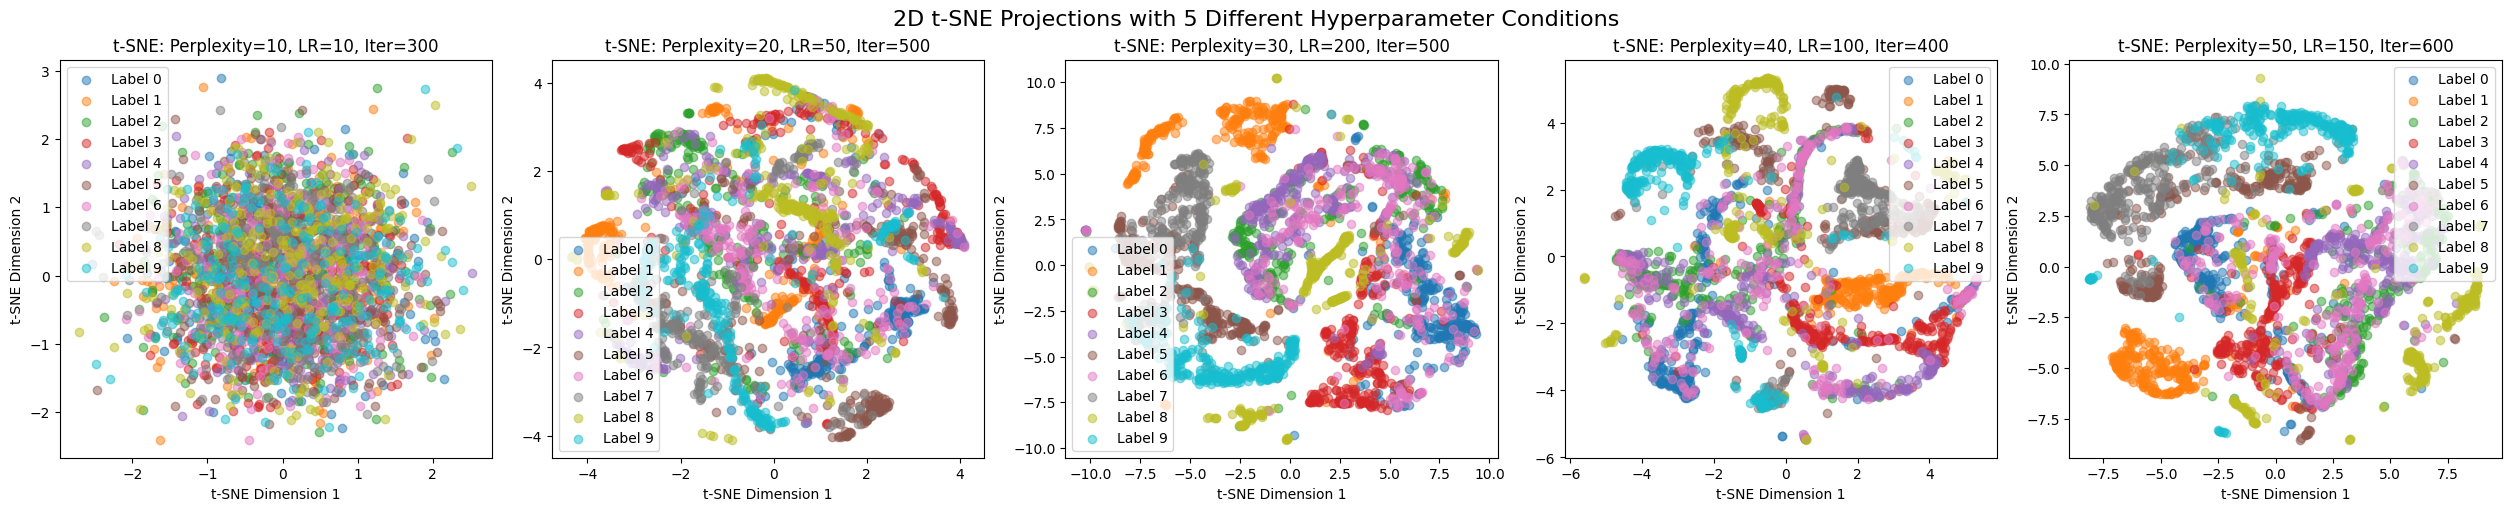

In [210]:
# Visualize t-SNE with best hyperparameters
best_result = max(results, key=lambda x: x['D'])
Y_tsne_best = tsne(normalized_features, **best_result['params'])

plt.figure(figsize=(10, 7))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(Y_tsne_best[idx, 0], Y_tsne_best[idx, 1], label=f'Label {label}', alpha=0.5)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('Best t-SNE with Optimized Hyperparameters')
plt.show()
